# Notebook to generate images for hypothesis figure.

This notebook saves PDF images of hypothesis schematics to the current
directory.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from pynwb import NWBHDF5IO
from PIL import Image
import ast


import sys
sys.path.append('../../../task_visualization')
import task_state as task_state_lib
import renderer as renderer_lib

In [ ]:
"""Load data."""

SUBJECT = "Perle"
SESSION = "2022-06-01"
TRIAL_NUMBER = 33

# Load the data
nwb_file_path = Path(
    f"../../../cache/dandi_data/behavior/sub-{SUBJECT}/"
    f"sub-{SUBJECT}_ses-{SESSION}_behavior+task.nwb"
)

# Read data from nwb file
with NWBHDF5IO(nwb_file_path, "r") as io:
    print(f"Processing {nwb_file_path}")
    nwbfile = io.read()
    all_trials_df = nwbfile.trials.to_dataframe()
    all_display_df = nwbfile.intervals['display'].to_dataframe()
    

# Compute trial and display dataframes for the selected trial
trial_df = all_trials_df.loc[TRIAL_NUMBER]
display_df = all_display_df[
    (all_display_df['start_time'] > trial_df['start_time']) &
    (all_display_df['stop_time'] < trial_df['stop_time'])
].reset_index(drop=True)

Processing ../../../cache_osf/data_for_figures/dandi_data/behavior/sub-Perle/sub-Perle_ses-2022-06-01_behavior+task.nwb


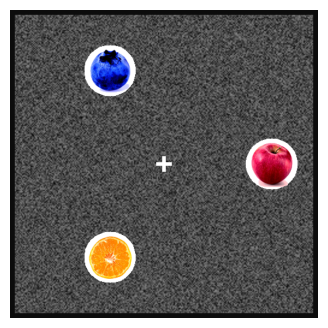

In [3]:
"""Render trial."""

# Get task state and renderer
stim_positions = ast.literal_eval(trial_df.stimulus_object_positions)
stim_identities = ast.literal_eval(trial_df.stimulus_object_identities)
stim_target_str = trial_df.stimulus_object_target
stim_target = stim_target_str[1:-1].split(", ")
stim_target = [x == 'true' for x in stim_target]
task_state = task_state_lib.get_task_state(
    stim_positions, stim_identities, stim_target)
for p in task_state['prey']:
    p.opacity = 255
task_state['eye'][0].opacity = 0
background_indices = trial_df.background_indices
renderer = renderer_lib.Renderer()

# Render stimulus
for p in task_state['prey']:
    p.opacity = 255
image = renderer(task_state, background_indices, blank=False)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.axis('off')
ax.imshow(image)
Image.fromarray(image).save('stimulus.pdf')

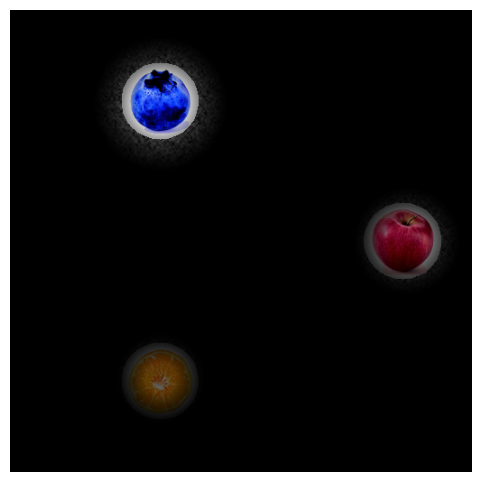

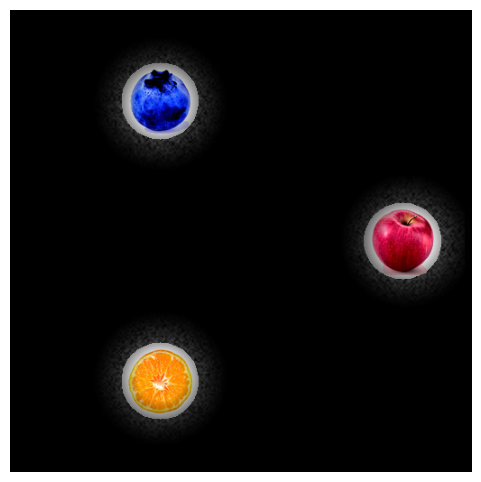

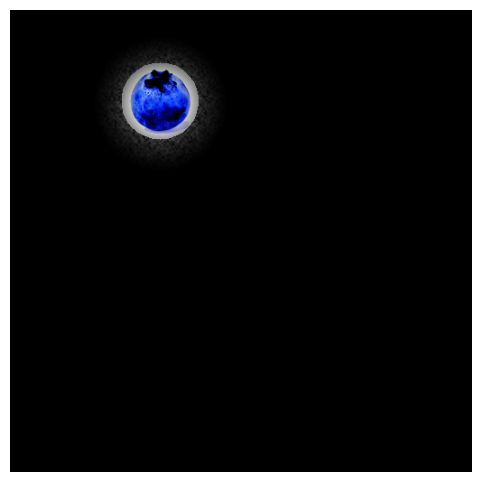

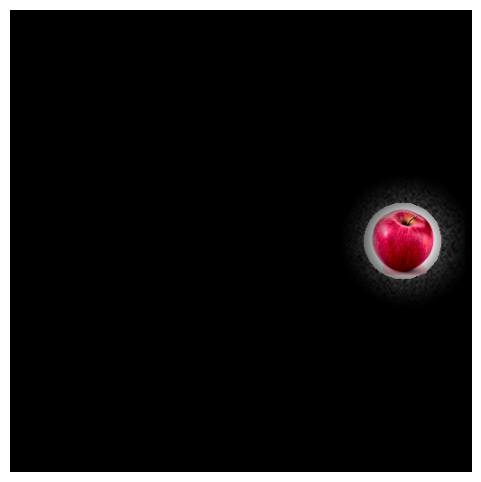

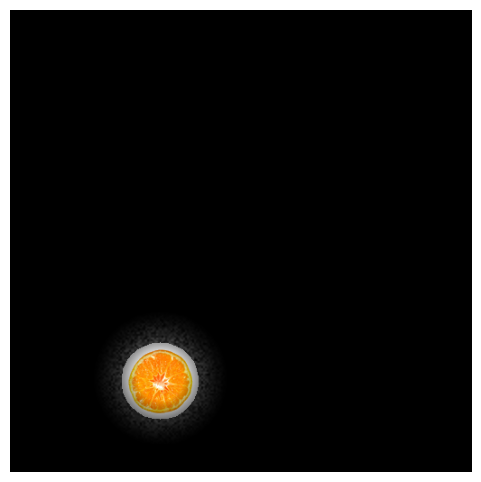

In [4]:
"""Overlay visibility."""

def _plot(sizes, alphas, title, positions=((167, 104), (440, 256), (167, 408))):
    # Convert image array to PIL image
    image_pil = Image.fromarray(image)

    # Get foveal window mask
    fw_raw = renderer._fw_raw

    # Get position and size
    fw_images = []
    for pos, size, alpha in zip(positions, sizes, alphas):
        fw_image = Image.new('L', renderer._image_size, 0)
        patch = fw_raw.resize((size, size))
        fw_image.paste(patch, (pos[0] - size // 2, pos[1] - size // 2))
        fw_images.append((fw_image, alpha))

    # Add fw_images together
    fw_image_blended_array = np.zeros(renderer._image_size, dtype=np.uint8)
    for fw_image, alpha in fw_images:
        fw_image_blended_array += (alpha * np.array(fw_image)).astype(np.uint8)
    fw_image_blended = Image.fromarray(fw_image_blended_array)

    # Mask around foveal window
    image_black = Image.new('RGB', renderer._image_size, 0)
    fw_image_negative = Image.fromarray(255 - np.array(fw_image_blended))
    image_pil.paste(image_black, (0, 0), fw_image_negative)

    # Mask in foveal window
    inside_mask = Image.fromarray((0.5 * (255 - np.array(fw_image_blended))).astype(np.uint8))
    image_pil.paste(image_black, (0, 0), inside_mask)

    # Render fw_image
    _, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.axis('off')
    ax.imshow(image_pil)
    
    # Save as pdf
    image_pil.save(title)

# Save stimulus gain image
_plot(
    sizes=(150, 120, 100),
    alphas=(1., 0.7, 0.5),
    title='gain.pdf',
)

# Save stimulus slots image
_plot(
    sizes=(150, 150, 150),
    alphas=(1., 1., 1.),
    title='slots.pdf',
)

# Save stimulus switching images
_plot(
    sizes=(150, 150, 150),
    alphas=(1., 0., 0.),
    title='switching_0.pdf',
)
_plot(
    sizes=(150, 150, 150),
    alphas=(0., 1., 0.),
    title='switching_1.pdf',
)
_plot(
    sizes=(150, 150, 150),
    alphas=(0., 0., 1.),
    title='switching_2.pdf',
)